<a href="https://colab.research.google.com/github/ppcodelearn/git_workshop/blob/main/connect_colabgithub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setting Tensorflow with TPU

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Data Analyst

*credit to https://miykael.github.io/blog/2022/advanced_eda/*

In [2]:
from sklearn.datasets import fetch_openml

# Download the dataset from openml
dataset = fetch_openml(data_id=42803, as_frame=True)

# Extract feature matrix X and show 5 random samples
df_X = dataset["frame"]

In [3]:
# Show size of the dataset
df_X.shape

(363243, 67)

In [4]:
# Display non-numerical features
df_X.select_dtypes(exclude="number").head()

,Accident_Index,Sex_of_Driver,Date,Time,Local_Authority_(Highway),LSOA_of_Accident_Location
0,201501BS70001,1.0,12/01/2015,18:45,E09000020,E01002825
1,201501BS70002,1.0,12/01/2015,07:50,E09000020,E01002820
2,201501BS70004,1.0,12/01/2015,18:08,E09000020,E01002833
3,201501BS70005,1.0,13/01/2015,07:40,E09000020,E01002874
4,201501BS70008,1.0,09/01/2015,07:30,E09000020,E01002814


In [5]:
# Changes data type of 'Sex_of_Driver'
df_X["Sex_of_Driver"] = df_X["Sex_of_Driver"].astype("float")

In [6]:
df_X.describe(exclude="number")

,Accident_Index,Date,Time,Local_Authority_(Highway),LSOA_of_Accident_Location
count,363243,319866,319822,319866,298758
unique,140056,365,1439,204,25979
top,201543P296025,14/02/2015,17:30,E10000017,E01028497
freq,1332,2144,2972,8457,1456


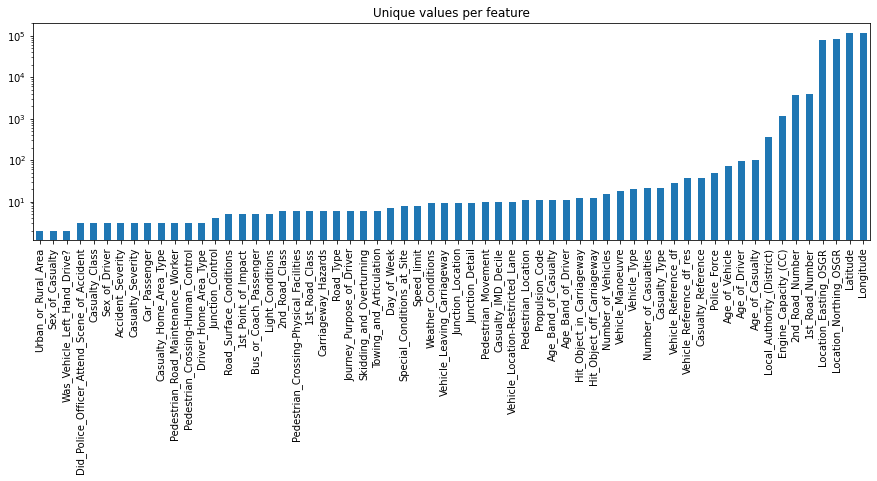

In [7]:
# For each numerical feature compute number of unique entries
unique_values = df_X.select_dtypes(include="number").nunique().sort_values()

# Plot information with y-axis in log-scale
unique_values.plot.bar(logy=True, figsize=(15, 4), title="Unique values per feature");

In [8]:
# Check number of duplicates while ignoring the index feature
n_duplicates = df_X.drop(labels=["Accident_Index"], axis=1).duplicated().sum()
print(f"You seem to have {n_duplicates} duplicates in your database.")

You seem to have 22 duplicates in your database.


In [9]:
#  Extract column names of all features, except 'Accident_Index'
columns_to_consider = df_X.drop(labels=["Accident_Index"], axis=1).columns

# Drop duplicates based on 'columns_to_consider'
df_X = df_X.drop_duplicates(subset=columns_to_consider)
df_X.shape

(363221, 67)

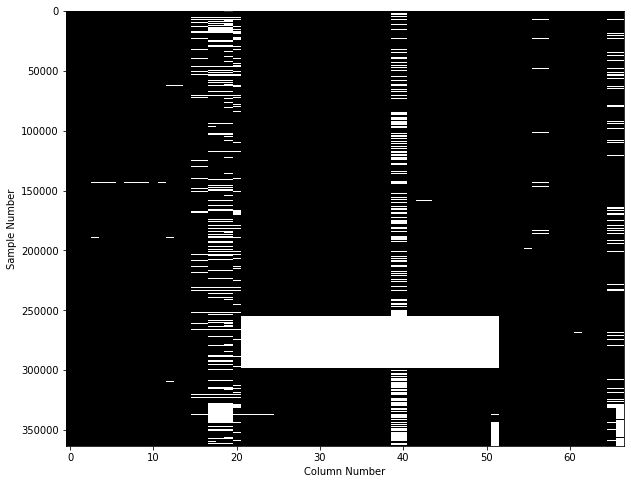

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(df_X.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number");

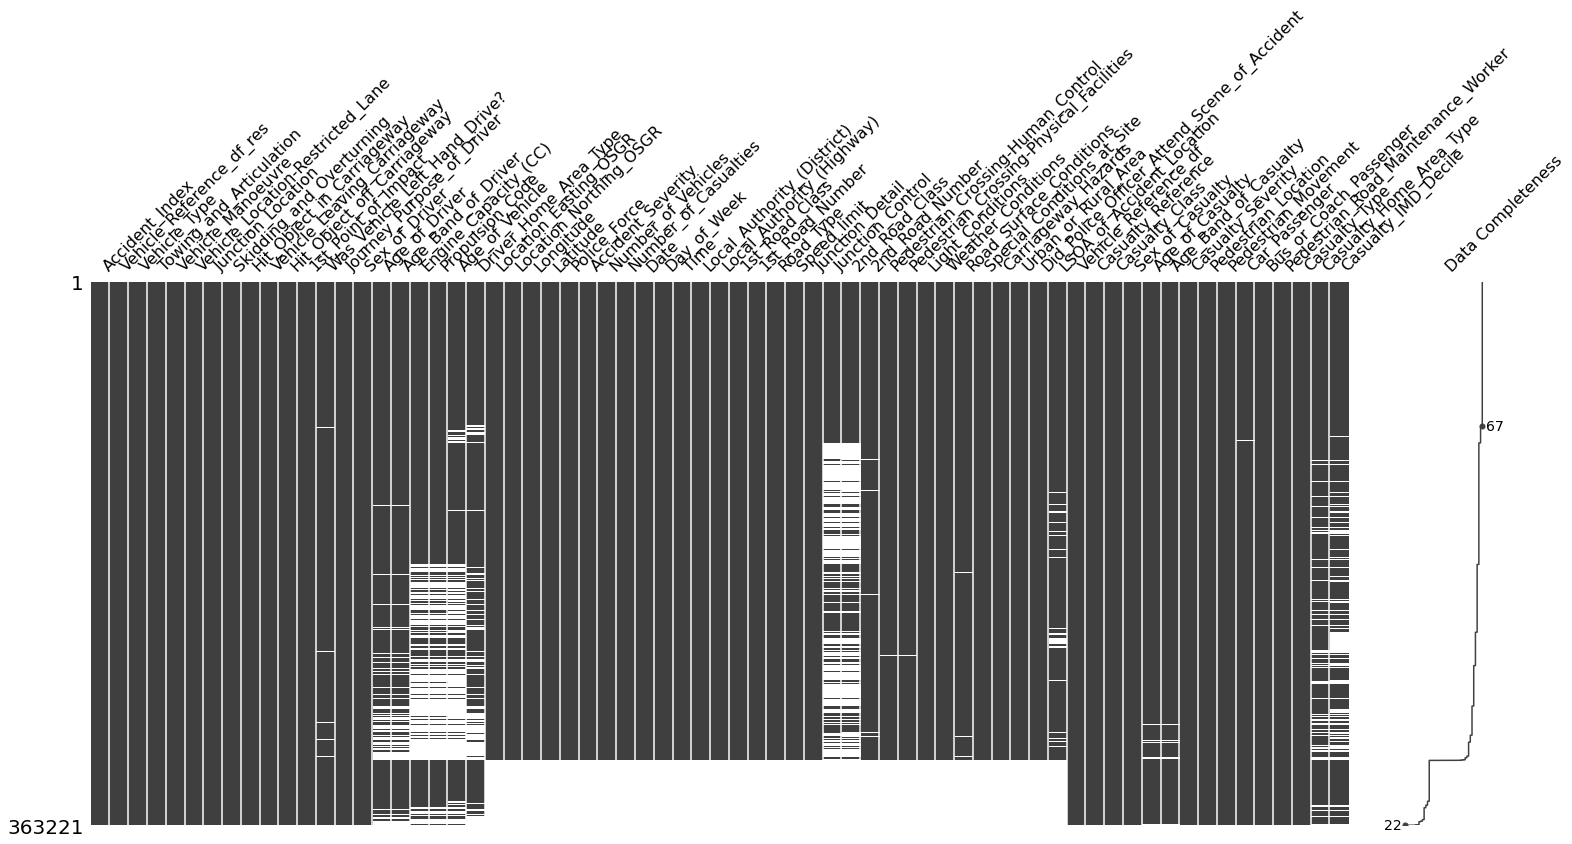

In [11]:
import missingno as msno

msno.matrix(df_X, labels=True, sort="descending");

In [12]:
df_X = df_X.dropna(thresh=df_X.shape[1] * 0.80, axis=0).reset_index(drop=True)
df_X.shape

(319790, 67)

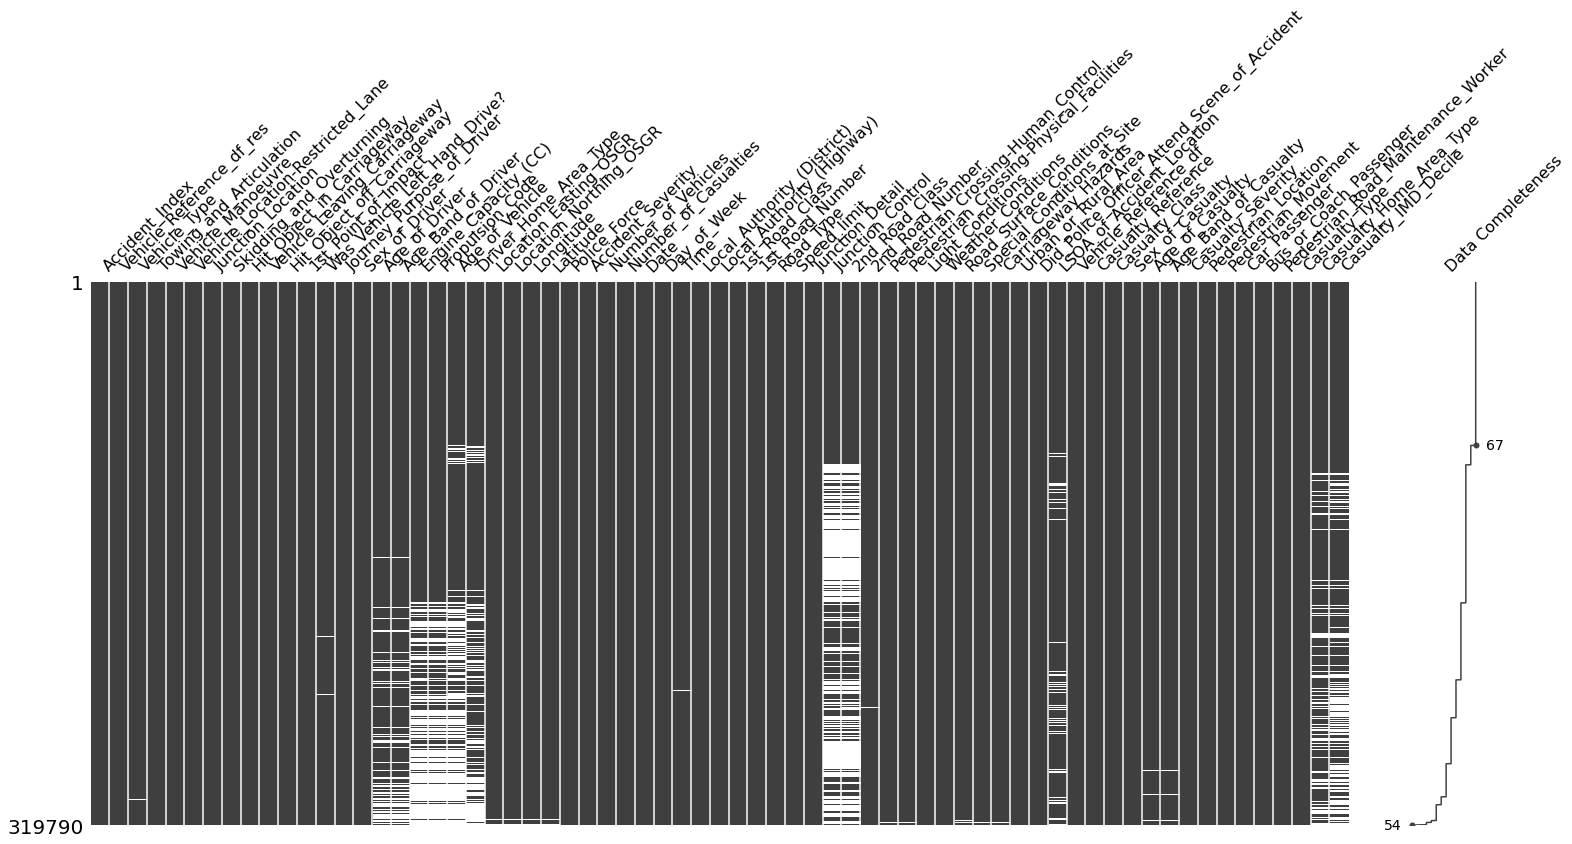

In [13]:
msno.matrix(df_X, labels=True, sort="descending");

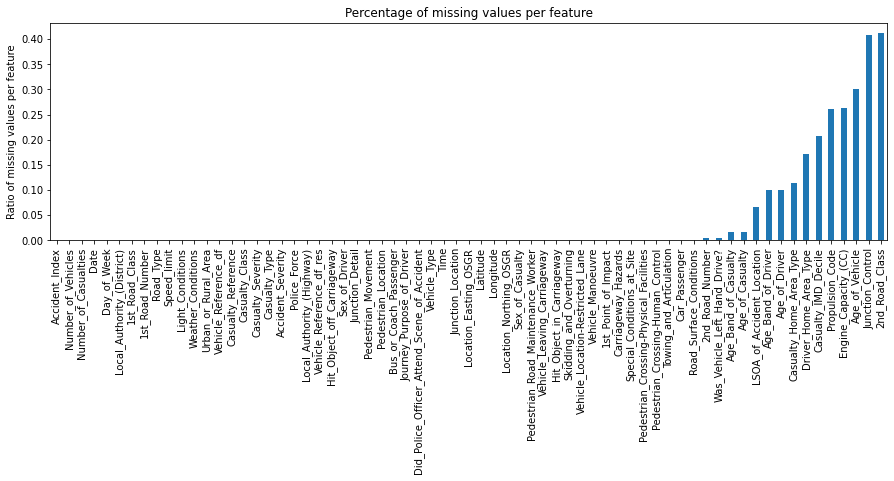

In [14]:
df_X.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4),
    title="Percentage of missing values per feature",
    ylabel="Ratio of missing values per feature");

In [15]:
df_X = df_X.dropna(thresh=df_X.shape[0] * 0.85, axis=1)
df_X.shape

(319790, 60)

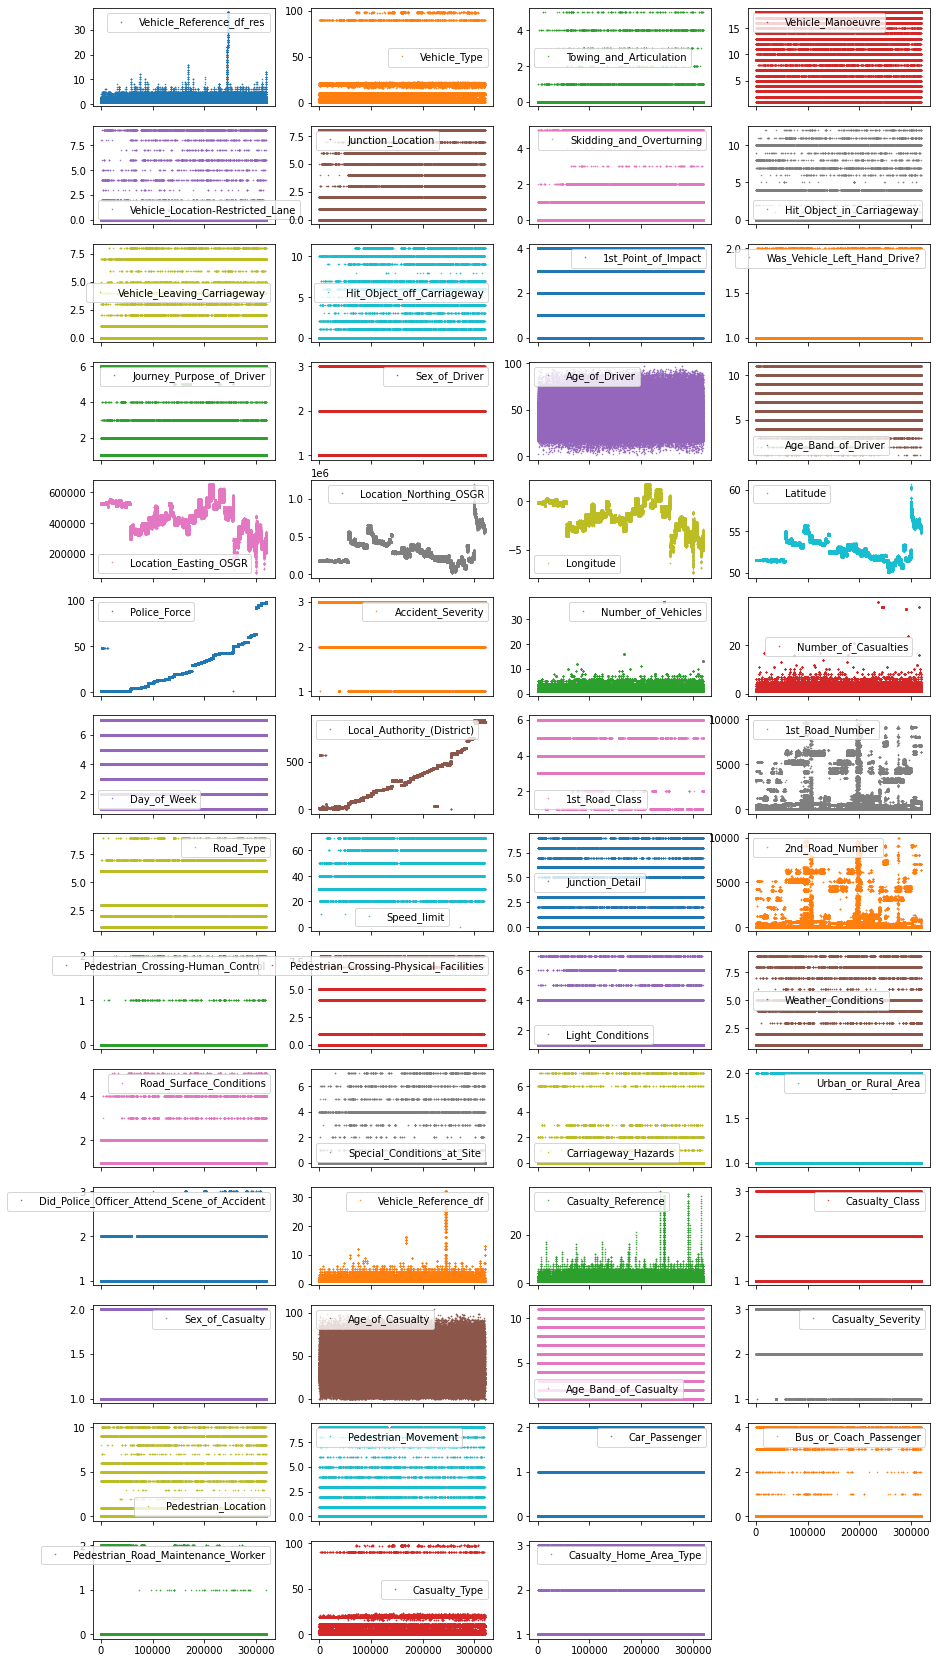

In [16]:
df_X.plot(lw=0, marker=".", subplots=True, layout=(-1, 4),
          figsize=(15, 30), markersize=1);

In [17]:
# Extract descriptive properties of non-numerical features
df_X.describe(exclude=["number", "datetime"])

,Accident_Index,Date,Time,Local_Authority_(Highway),LSOA_of_Accident_Location
count,319790,319790,319746,319790,298693
unique,123645,365,1439,204,25977
top,201543P296025,14/02/2015,17:30,E10000017,E01028497
freq,1332,2144,2969,8457,1456


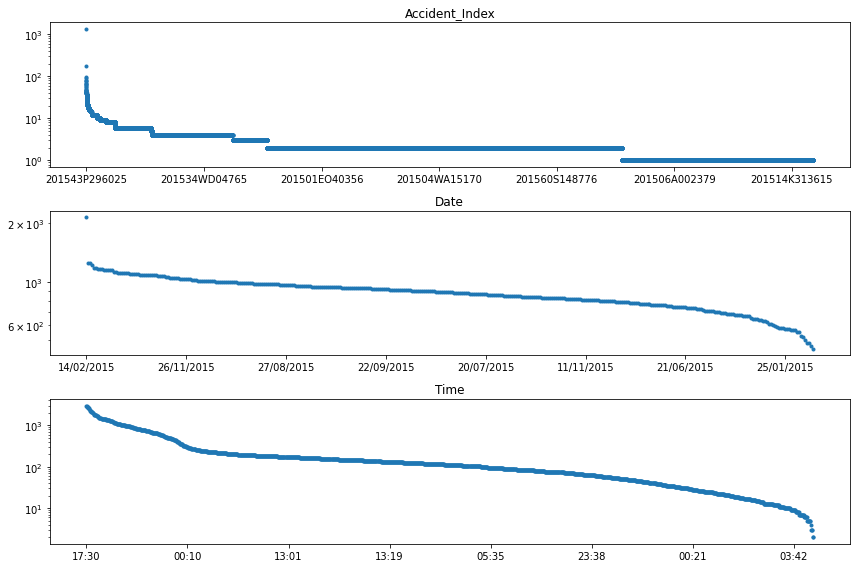

In [18]:
# Create figure object with 3 subplots
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(12, 8))

# Identify non-numerical features
df_non_numerical = df_X.select_dtypes(exclude=["number", "datetime"])

# Loop through features and put each subplot on a matplotlib axis object
for col, ax in zip(df_non_numerical.columns, axes.ravel()):

    # Selects one single feature and counts number of occurrences per unique value
    df_non_numerical[col].value_counts().plot(

        # Plots this information in a figure with log-scaled y-axis
        logy=True, title=col, lw=0, marker=".", ax=ax)
    
plt.tight_layout();

In [19]:
# Collect entry values of the 10 most frequent accidents
accident_ids = df_non_numerical["Accident_Index"].value_counts().head(10).index
# Removes accidents from the 'accident_ids' list
df_X = df_X[~df_X["Accident_Index"].isin(accident_ids)]
df_X.shape

(317665, 60)

''

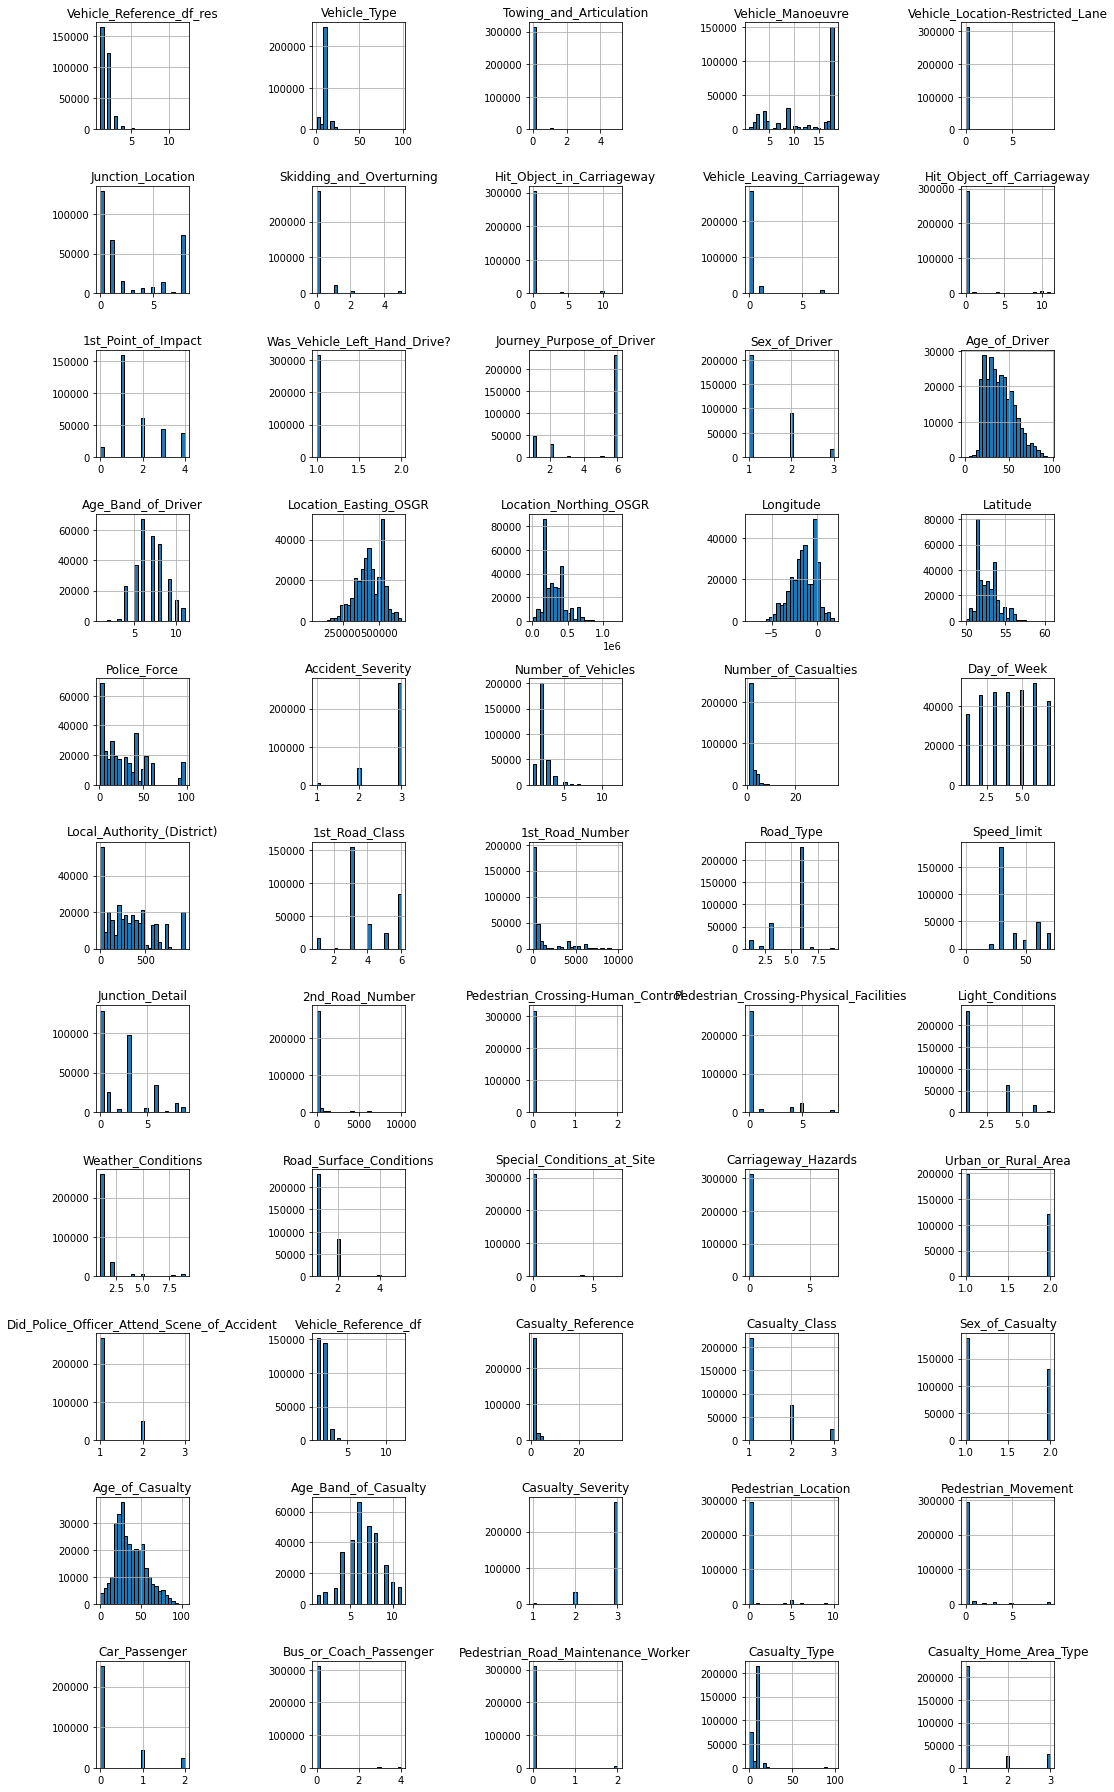

In [20]:
# Plots the histogram for each numerical feature in a separate subplot
df_X.hist(bins=25, figsize=(15, 25), layout=(-1, 5), edgecolor="black")
plt.tight_layout();''

Pedestrian_Crossing-Human_Control    0.995259
Was_Vehicle_Left_Hand_Drive?         0.990137
Carriageway_Hazards                  0.983646
Towing_and_Articulation              0.983221
Vehicle_Location-Restricted_Lane     0.982088
dtype: float64

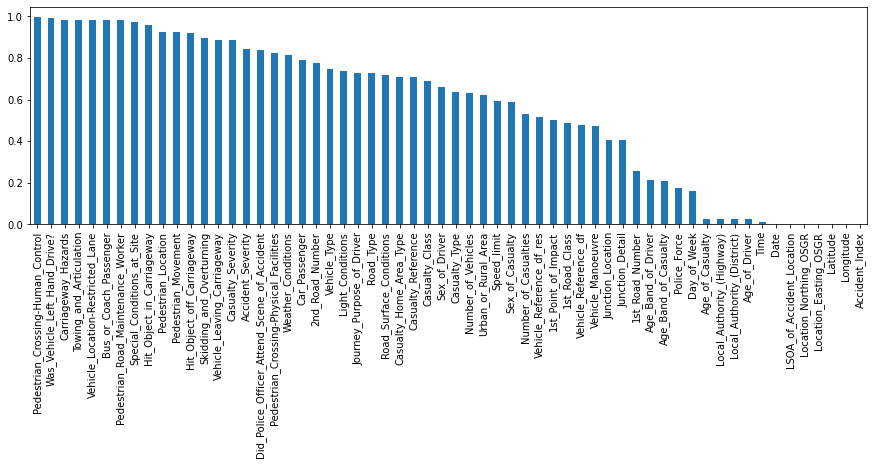

In [21]:
# Collects for each feature the most frequent entry
most_frequent_entry = df_X.mode()

# Checks for each entry if it contains the most frequent entry
df_freq = df_X.eq(most_frequent_entry.values, axis=1)

# Computes the mean of the 'is_most_frequent' occurrence
df_freq = df_freq.mean().sort_values(ascending=False)

# Show the 5 top features with the highest ratio of singular value content
display(df_freq.head())

# Visualize the 'df_freq' table
df_freq.plot.bar(figsize=(15, 4));

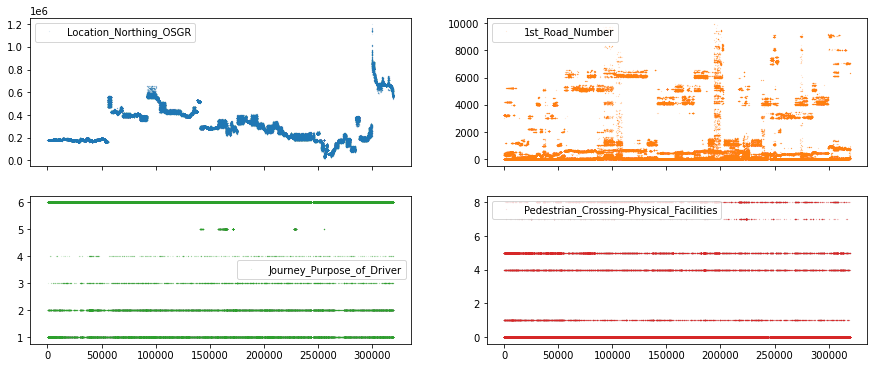

In [22]:
df_X[["Location_Northing_OSGR", "1st_Road_Number",
      "Journey_Purpose_of_Driver", "Pedestrian_Crossing-Physical_Facilities"]].plot(
    lw=0, marker=".", subplots=True, layout=(-1, 2), markersize=0.1, figsize=(15, 6));

In [23]:
# Creates mask to identify numerical features with more or less than 25 unique features
cols_continuous = df_X.select_dtypes(include="number").nunique() >= 25

In [24]:
# Create a new dataframe which only contains the continuous features
df_continuous = df_X[cols_continuous[cols_continuous].index]
df_continuous.shape

(317665, 11)

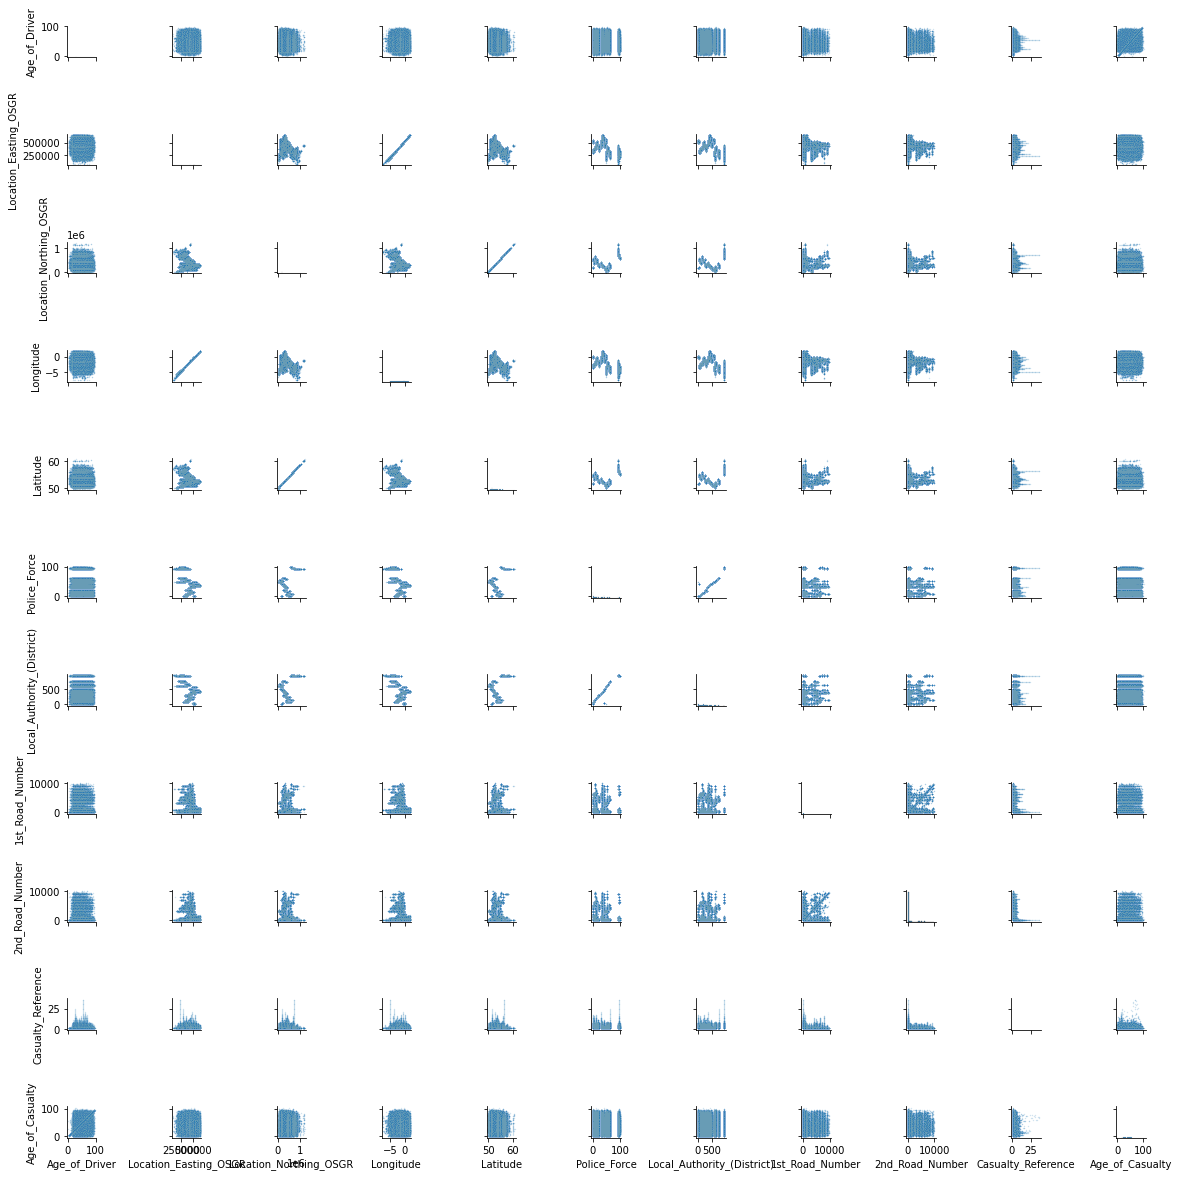

In [25]:
import seaborn as sns

sns.pairplot(df_continuous, height=1.5, plot_kws={"s": 2, "alpha": 0.2});

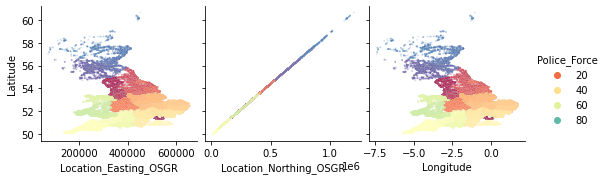

In [26]:
sns.pairplot(
    df_X, plot_kws={"s": 3, "alpha": 0.2}, hue="Police_Force", palette="Spectral",
    x_vars=["Location_Easting_OSGR", "Location_Northing_OSGR", "Longitude"],
    y_vars="Latitude");